In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('.')

In [2]:
from argparse import Namespace
import pickle

import pyro
from pyro import distributions as dist
import torch
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, config_enumerate, Predictive
from pyro.infer.discrete import infer_discrete, TraceEnumSample_ELBO
from pyro.infer.autoguide import AutoDiscreteParallel, AutoDelta, AutoGuideList, AutoDiagonalNormal
from pyro import poutine

from src.pgm import utils

pyro.enable_validation(True)

![](https://miro.medium.com/max/1400/0*Ws_1F7ZFdbqph4Y8.)

$$\mathbb{P}(\texttt{Difficulty} = d) \sim \texttt{Bernoulli}(\theta^D),\; d \in \{0, 1\}$$

$$\mathbb{P}(\texttt{Intelligence} = i) \sim  \texttt{Bernoulli}(\theta^I),\; i \in \{0, 1\}$$

$$\mathbb{P}(\texttt{Grade} = g\; |\; \texttt{Difficulty} = d, \texttt{Intelligence} = i) \sim \texttt{Cat}(\theta^G_{d, i}),\; g \in \{0, 1, 2\}$$

$$\mathbb{P}(\texttt{SAT} = s\; |\; \texttt{Intelligence} = i) \sim \texttt{Bernoulli}(\theta^S_i),\; s \in \{0, 1\}$$

$$\mathbb{P}(\texttt{Letter} = l \;|\; \texttt{Grade} = g) \sim \texttt{Bernoulli}(\theta^L_g),\; l \in \{0, 1\}$$

## Read data
Columns:
- Difficulty
- Intelligence
- SAT
- Grade
- Letter

In [3]:
with open('data/pgm-student-data.pkl', 'rb') as fin:
    full_data = torch.tensor(pickle.load(fin), dtype=torch.float)

# Full-data model (no enumeration)

In [4]:
def model_1(x):
    # Parameters
    theta_D = pyro.param(
        'theta_D', 
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1), # works element-wise
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.ones(2,2,3).div(3),
        constraint=constraints.simplex, # works row-wise
    )
    
    theta_L = pyro.param(
        'theta_L',
        torch.tensor([0.5, 0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample('Difficulty', dist.Bernoulli(probs=theta_D), obs=x.d).long()
        i = pyro.sample('Intelligence', dist.Bernoulli(probs=theta_I), obs=x.i).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()
        g = pyro.sample('Grade', dist.Categorical(probs=theta_G[i, d]), obs=x.g).long()

        l = pyro.sample('Letter', dist.Bernoulli(probs=theta_L[g]), obs=x.l).long()
    
        res = torch.stack([d, i, s, g, l]).t()
        return res

    
def guide_1(x):
    pass

Loss = 1935.6008911132812
Loss = 1673.1929016113281
Loss = 1553.639175415039
Loss = 1494.2175598144531
Loss = 1461.4694519042969
Loss = 1442.0335998535156
Loss = 1429.8786163330078
Loss = 1421.965835571289
Loss = 1416.6472625732422
Loss = 1412.9775085449219
Loss = 1410.387466430664
Loss = 1408.523193359375
Loss = 1407.1567687988281
Loss = 1406.1390991210938
Loss = 1405.3691711425781
Loss = 1404.7789306640625
Loss = 1404.320053100586
Loss = 1403.9591522216797
Loss = 1403.6714782714844
Loss = 1403.4400482177734



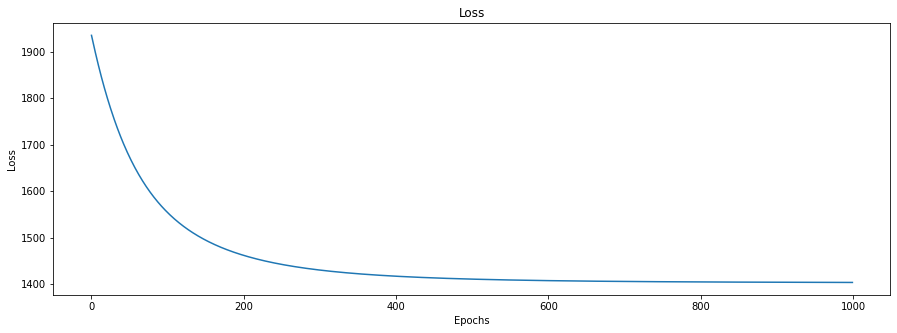

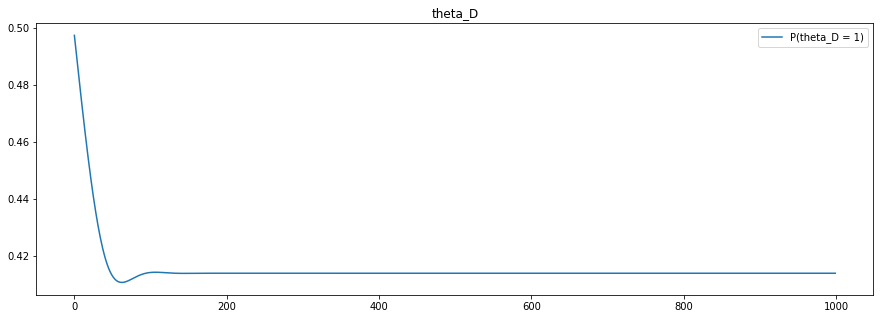

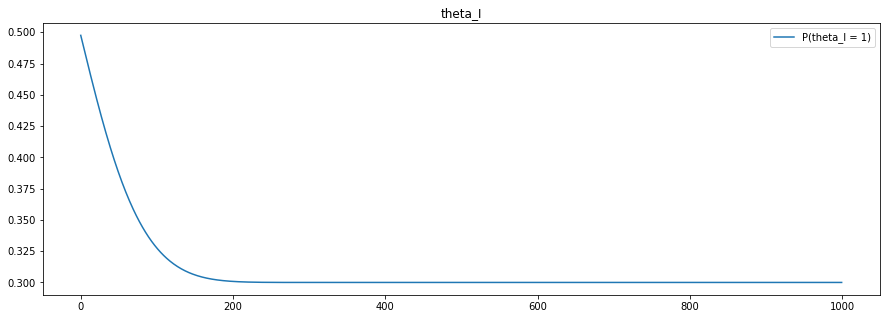

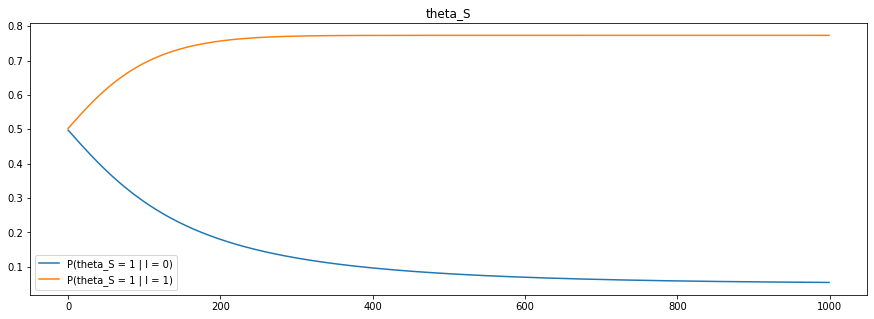

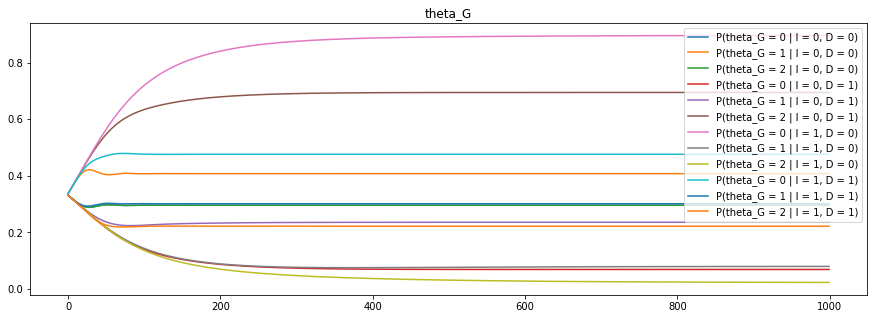

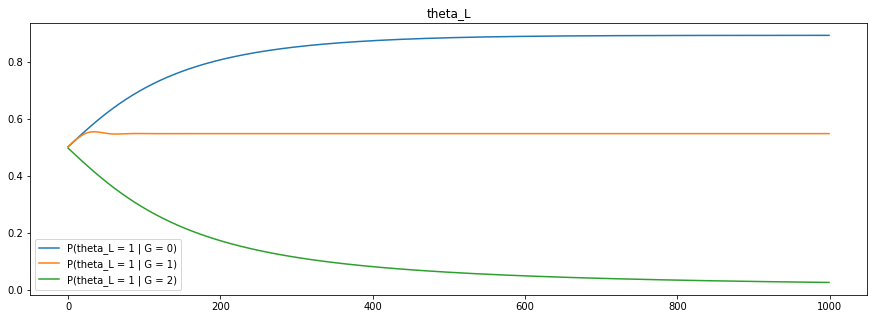

In [5]:
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)

pyro.clear_param_store()

hist = utils.train_svi(model=model_1, guide=guide_1, X=x, num_epochs=1_000, lr=1e-2, loss=Trace_ELBO())

utils.visualize_nb_parameters(hist)

In [6]:
for pname, pval in dict(pyro.get_param_store()).items():
    print(pname, pval.detach().numpy())

theta_D 0.41399997
theta_I 0.29999998
theta_S [0.05402604 0.7733332 ]
theta_G [[[0.2961165  0.40776697 0.2961165 ]
  [0.06944451 0.23611104 0.6944445 ]]

 [[0.8961368  0.08023369 0.02362951]
  [0.47619045 0.3015873  0.22222225]]]
theta_L [0.8938126  0.5486111  0.02581277]


We did not use Variational Inference in this example, but normal gradient-based optimization. Each site is observable so we do not deal with one big computational graph but rather with 5 (number of sites) small ones - to be exact, more graphs are created here, one for each combination of parents.

Categorical and Bernoulli distributions can not be reparametrized, but `pyro` helps us with gradient approximation.

In case of reparametrizable random variables we could have done this manually.

# Partial observation model (no enumeration)

Grade is not observed.

In [7]:
def model_2(x):
    # Parameters
    theta_D = pyro.param(
        'theta_D', 
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.ones(2,2,3).div(3),
        constraint=constraints.simplex,
    )
    
    theta_L = pyro.param(
        'theta_L',
        torch.tensor([0.5, 0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample('Difficulty', dist.Bernoulli(probs=theta_D), obs=x.d).long()
        i = pyro.sample('Intelligence', dist.Bernoulli(probs=theta_I), obs=x.i).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()
        # Grade not observed
        g = pyro.sample('Grade', dist.Categorical(probs=theta_G[i, d])).long()

        l = pyro.sample('Letter', dist.Bernoulli(probs=theta_L[g]), obs=x.l).long()
    
        res = torch.stack([d, i, s, g, l]).t()
        return res

    
def guide_2(x):
    pass

/usr/local/lib/python3.7/site-packages/pyro/util.py:210: UserWarning: Found vars in model but not guide: {'Grade'}
  warnings.warn("Found vars in model but not guide: {}".format(model_vars - guide_vars - enum_vars))


Loss = 1935.6008911132812
Loss = 1812.7680969238281
Loss = 1760.7438201904297
Loss = 1729.1668701171875
Loss = 1716.6521759033203
Loss = 1704.3294372558594
Loss = 1696.5668487548828
Loss = 1693.3100128173828
Loss = 1690.1949157714844
Loss = 1683.2346801757812
Loss = 1676.3431701660156
Loss = 1674.4373474121094
Loss = 1686.6188201904297
Loss = 1682.1499938964844
Loss = 1685.6061096191406
Loss = 1678.1895141601562
Loss = 1690.2603607177734
Loss = 1680.5535125732422
Loss = 1675.3994598388672
Loss = 1678.2103729248047



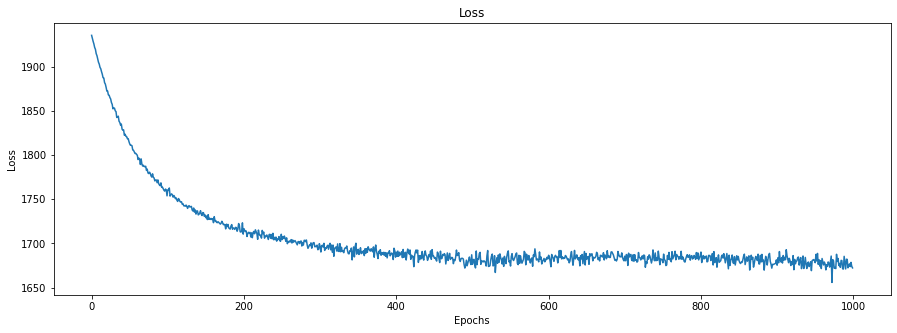

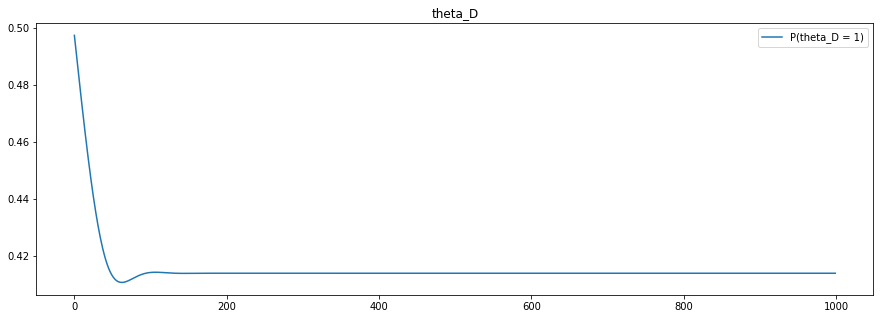

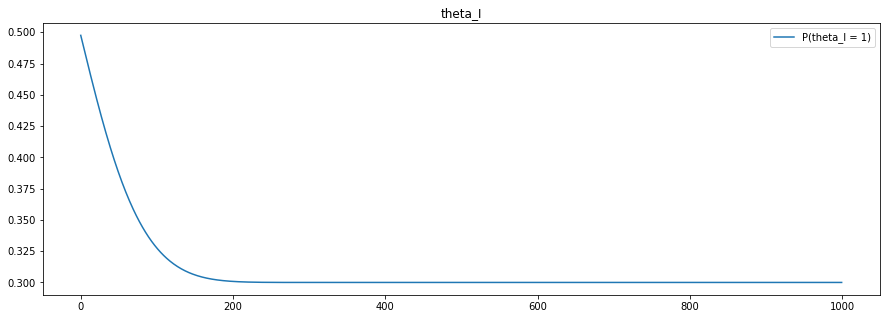

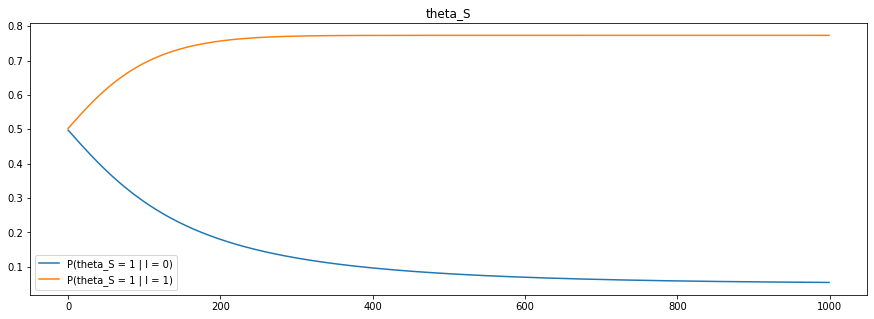

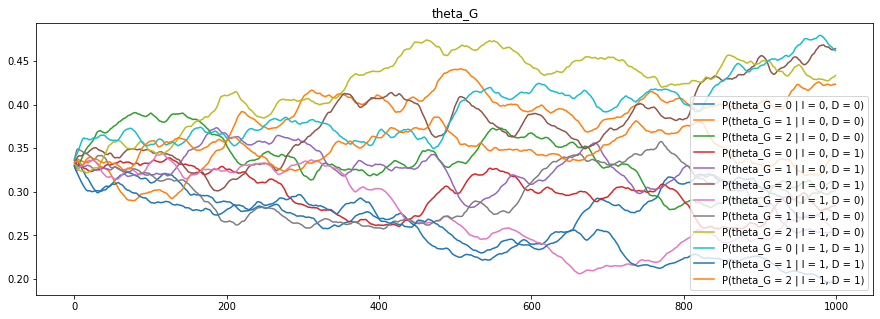

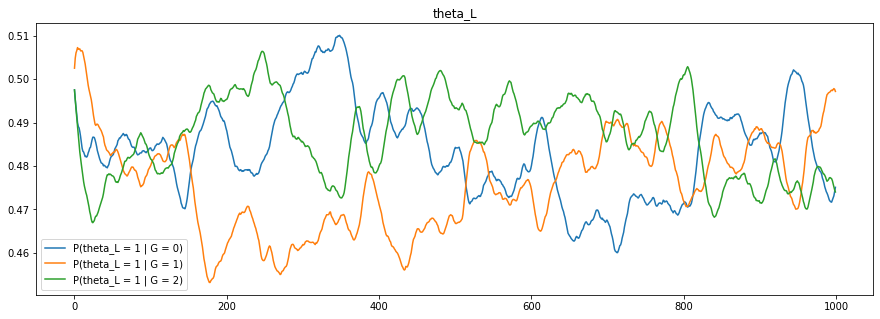

In [8]:
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)

pyro.clear_param_store()

hist = utils.train_svi(model=model_2, guide=guide_2, X=x, num_epochs=1_000, lr=1e-2)

utils.visualize_nb_parameters(hist)

For SVI all sites in model must best present in the guide, except for:
- observable sites (covered in the full-model)
- enumerated sites (will be covered during this laboratory)

In [10]:
def model_3(x):
    # Parameters
    theta_D = pyro.param(
        'theta_D', 
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = torch.ones(2,2,3).div(3)
    
    theta_L = pyro.param(
        'theta_L',
        torch.tensor([0.5, 0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample('Difficulty', dist.Bernoulli(probs=theta_D), obs=x.d).long()
        i = pyro.sample('Intelligence', dist.Bernoulli(probs=theta_I), obs=x.i).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()
        # Grade not observed
        g = pyro.sample('Grade', dist.Categorical(probs=theta_G[i, d])).long()

        l = pyro.sample('Letter', dist.Bernoulli(probs=theta_L[g]), obs=x.l).long()
    
        res = torch.stack([d, i, s, g, l]).t()
        return res

    
def guide_3(x):
    theta_G = pyro.param(
        'theta_G', 
        torch.tensor([
            [[0.3, 0.3, 0.3], [0.3, 0.3, 0.3]],
            [[0.3, 0.3, 0.3], [0.3, 0.3, 0.3]]
        ]),
        constraint=constraints.simplex,
    )
    
    with pyro.plate('data', x.shape[0]):
        # Difficulty and Intelligence are observable, so we can extract it directly from x
        g = pyro.sample('Grade', dist.Categorical(probs=theta_G[x.i.long(), x.d.long()])).long()

Loss = 1386.29443359375
Loss = 1266.0521240234375
Loss = 1212.5113983154297
Loss = 1182.0796203613281
Loss = 1169.1122283935547
Loss = 1159.1934814453125
Loss = 1153.6355743408203
Loss = 1150.1855010986328
Loss = 1149.0498962402344
Loss = 1146.3096618652344
Loss = 1143.5365600585938
Loss = 1142.4818725585938
Loss = 1143.7704315185547
Loss = 1142.9060974121094
Loss = 1142.0337219238281
Loss = 1141.708740234375
Loss = 1142.7961883544922
Loss = 1141.7003326416016
Loss = 1143.9041595458984
Loss = 1142.896743774414



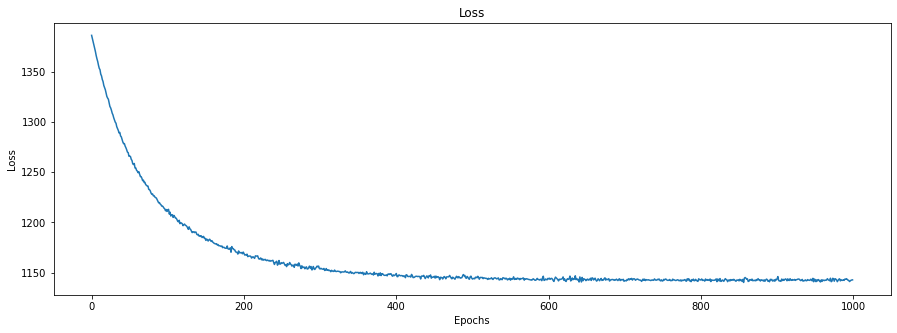

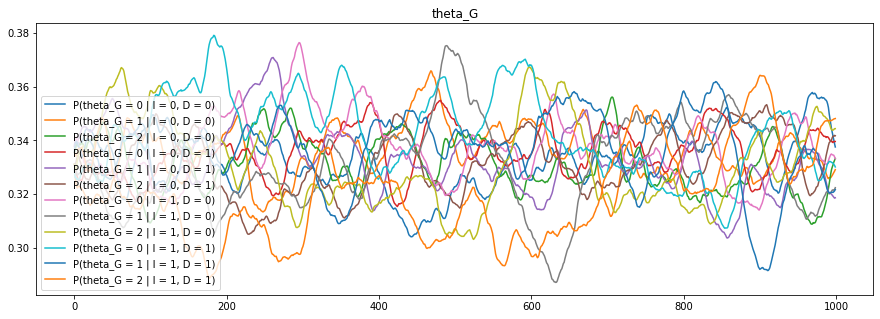

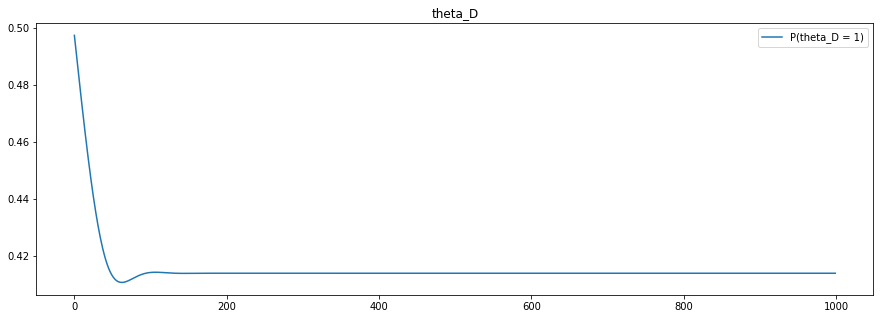

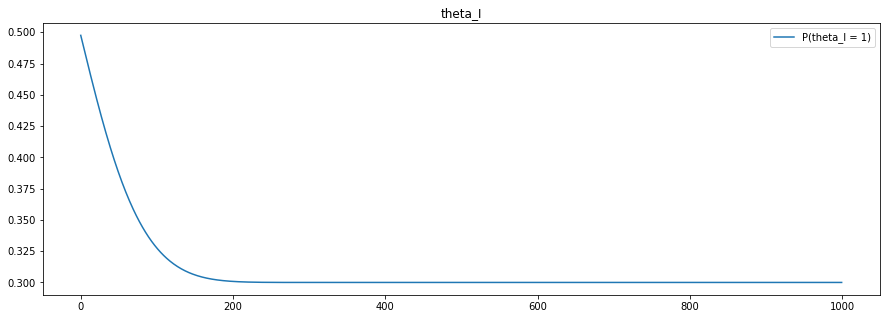

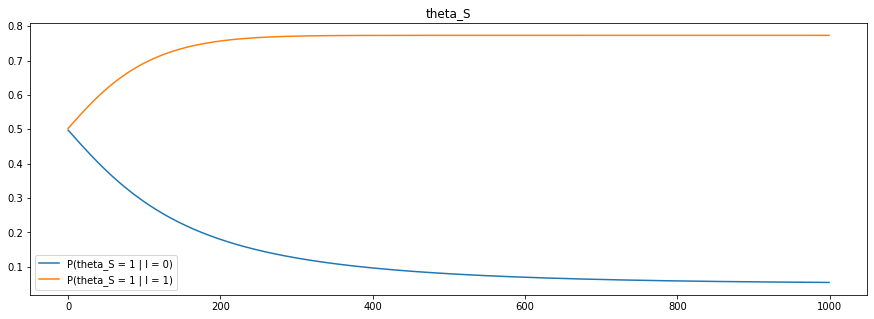

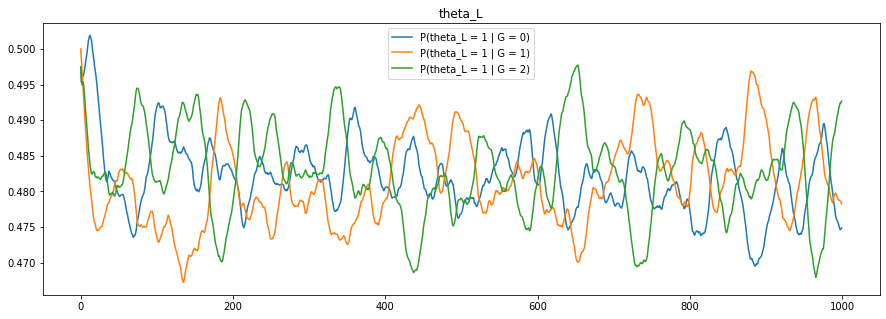

In [11]:
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)

pyro.clear_param_store()

hist = utils.train_svi(model=model_3, guide=guide_3, X=x, num_epochs=1_000, lr=1e-2)

utils.visualize_nb_parameters(hist)

Here we did apply Variational Inference. We have posed a (noninformative) prior on `theta_G`, introduced an approximating distribution in the guide and initialized its parameters.

### Let's observe only the leaf nodes - that is SAT and Letter

In [ ]:
def model_4(x):
    # Parameters
    theta_D = torch.tensor(0.5)
    theta_I = torch.tensor(0.5)
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = torch.ones(2,2,3).div(3)
    
    theta_L = pyro.param(
        'theta_L',
        torch.tensor([0.5, 0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample('Difficulty', dist.Bernoulli(probs=theta_D)).long()
        i = pyro.sample('Intelligence', dist.Bernoulli(probs=theta_I)).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()
        # Grade not observed
        g = pyro.sample('Grade', dist.Categorical(probs=theta_G[i, d])).long()

        l = pyro.sample('Letter', dist.Bernoulli(probs=theta_L[g]), obs=x.l).long()
    
        res = torch.stack([d, i, s, g, l]).t()
        return res

    
def guide_4(x):
    theta_D = pyro.param(
        'theta_D', 
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.tensor([
            [[0.3, 0.3, 0.3], [0.3, 0.3, 0.3]],
            [[0.3, 0.3, 0.3], [0.3, 0.3, 0.3]]
        ]),
        constraint=constraints.simplex,
    )
    
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample('Difficulty', dist.Bernoulli(probs=theta_D)).long()
        i = pyro.sample('Intelligence', dist.Bernoulli(probs=theta_I)).long()
        # Difficulty and Intelligence are not observable anymore, so we relay on the sampled values
        g = pyro.sample('Grade', dist.Categorical(probs=theta_G[i, d])).long()

In [ ]:
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)

pyro.clear_param_store()

hist = utils.train_svi(model=model_4, guide=guide_4, X=x, num_epochs=1_000, lr=1e-2)

utils.visualize_nb_parameters(hist)

# But gradient approximations are not the best solutions in case of discrete distributions

A (possibly) better idea is to marginalize out discrete latent variables and optimize the remaining parts of the model without the noisy gradient approximations. That allows to use a higher learning rate and train more quickly and reliably than `Trace_ELBO`.

Latter we will be able to acces their marginals via belief propagation - it will be covered during this laboratory.

The theory standing behind the implementation of `pyro`'s variable elimination scheme is desribed in [this paper](https://arxiv.org/abs/1902.03210).

Additionally the higher-order gradients of ELBO (inevitable when dealing with PGMs) are constructed using *DiCE factors* as described in [this paper](https://arxiv.org/abs/1802.05098)

Most of the information covered in the ramining part of this notebook can be found in the [Inference with Discrete Latent Variables](https://pyro.ai/examples/enumeration.html) `pyro` tutorial which has been already mentioned a few times during this course.

## Let's return to the situation where Grade is not observed

We can annotate a site in two ways:
- `infer={"enumerate": "parallel"}` - the default and more efficient way
- `infer={"enumerate": "sequential"}` - if a sample site determines downstream structure

Here we use `"parallel"` enumeration, because `Grade` determines only specific row of parameters, not the general flow.

In [ ]:
def model_5(x, verbose=False):
    # Parameters
    theta_D = pyro.param(
        'theta_D', 
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.ones(2,2,3).div(3),
        constraint=constraints.simplex,
    )
    
    theta_L = pyro.param(
        'theta_L',
        torch.tensor([0.5, 0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample('Difficulty', dist.Bernoulli(probs=theta_D), obs=x.d).long()
        i = pyro.sample('Intelligence', dist.Bernoulli(probs=theta_I), obs=x.i).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()
        # Grade not observed but enumerated
        g = pyro.sample(
            'Grade',
            dist.Categorical(probs=theta_G[i, d]),
            infer={"enumerate": "parallel"}
        ).long()

        l = pyro.sample('Letter', dist.Bernoulli(probs=theta_L[g]), obs=x.l).long()
    
    if verbose:
        print(f'd.shape = {d.shape}')
        print(f'i.shape = {i.shape}')
        print(f's.shape = {s.shape}')
        print(f'g.shape = {g.shape} - {g}')
        print(f'l.shape = {l.shape}')
    
    if g.dim() == 1:
        return torch.stack([d, i, s, g, l]).t()
    else:
        res = []
        for g_value in g:
            res.append(torch.stack([
                d,
                i,
                s,
                torch.full((x.shape[0],), g_value.item()).long(),
                l
            ]).t())
        return res

    
def guide_5(x, verbose=False):
    pass

In [ ]:
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)

pyro.clear_param_store()

elbo = TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(model_5, guide_5, x, True)

In [ ]:
pyro.clear_param_store()

hist = utils.train_svi(model=model_5, guide=guide_5, X=x, num_epochs=1_000, lr=1e-2, loss=TraceEnum_ELBO())

utils.visualize_nb_parameters(hist)

You may want to examine the marginal probabilities for enumerated sites.

When you have a compound model with known probability tables you can use `compute_marginals` without any optimization.

In [ ]:
marginals = elbo.compute_marginals(model_5, guide_5, x)
marginals['Grade'].log_prob(torch.tensor(1)).exp()

But how `pyro` optimizes the parameters when no gradient approximation is performed? Check the papers! :)

### Let's return to the case when we observe only the leaf nodes - that is SAT and Letter

In [ ]:
def model_6(x, verbose=False):
    # Parameters
    theta_D = pyro.param(
        'theta_D', 
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.ones(2,2,3).div(3),
        constraint=constraints.simplex,
    )
    
    theta_L = pyro.param(
        'theta_L',
        torch.tensor([0.5, 0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample(
            'Difficulty',
            dist.Bernoulli(probs=theta_D),
            infer={"enumerate": "parallel"}
        ).long()
        i = pyro.sample(
            'Intelligence',
            dist.Bernoulli(probs=theta_I),
            infer={"enumerate": "parallel"}
        ).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()
        # Grade not observed but enumerated
        g = pyro.sample(
            'Grade',
            dist.Categorical(probs=theta_G[i, d]),
            infer={"enumerate": "parallel"}
        ).long()

        l = pyro.sample('Letter', dist.Bernoulli(probs=theta_L[g]), obs=x.l).long()
    
    if verbose:
        print(f'd.shape = {d.shape}')
        print(f'i.shape = {i.shape}')
        print(f's.shape = {s.shape}')
        print(f'g.shape = {g.shape}')
        print(f'l.shape = {l.shape}')
        
    # we skip returning anything from the model

    
def guide_6(x, verbose=False):
    pass

In [ ]:
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)

pyro.clear_param_store()

elbo = TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(model_6, guide_6, x, True)

In [ ]:
pyro.clear_param_store()

hist = utils.train_svi(model=model_6, guide=guide_6, X=x, num_epochs=1_000, lr=1e-2, loss=TraceEnum_ELBO(max_plate_nesting=1))

utils.visualize_nb_parameters(hist)

# Partially observed variables

Let's say we have partially observed `Inteligence` indicator. We want to use observed values and infer the missing part.

We can use [`poutine.mask`](http://docs.pyro.ai/en/stable/poutine.html#pyro.poutine.handlers.mask)

In [ ]:
def model_7(x, i_mask, verbose=False):
    # Parameters
    theta_D = pyro.param(
        'theta_D', 
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.ones(2,2,3).div(3),
        constraint=constraints.simplex,
    )
    
    theta_L = pyro.param(
        'theta_L',
        torch.tensor([0.5, 0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample(
            'Difficulty',
            dist.Bernoulli(probs=theta_D),
            infer={"enumerate": "parallel"}
        ).long()
        with poutine.mask(mask=i_mask):
            i = pyro.sample(
                'Intelligence',
                dist.Bernoulli(probs=theta_I),
                infer={"enumerate": "parallel"},
                obs=x.i
            ).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()
        # Grade not observed but enumerated
        g = pyro.sample(
            'Grade',
            dist.Categorical(probs=theta_G[i, d]),
            infer={"enumerate": "parallel"}
        ).long()

        l = pyro.sample('Letter', dist.Bernoulli(probs=theta_L[g]), obs=x.l).long()
    
    if verbose:
        print(f'd.shape = {d.shape}')
        print(f'i.shape = {i.shape}')
        print(f's.shape = {s.shape}')
        print(f'g.shape = {g.shape}')
        print(f'l.shape = {l.shape}')
        
    # we skip returning anything from the model

    
def guide_7(x, i_mask, verbose=False):
    pass

In [ ]:
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)

i_mask = torch.rand((full_data.shape[0],)) > 0.6

pyro.clear_param_store()

elbo = TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(model_7, guide_7, x, i_mask, True)

In [ ]:
i_mask.unique(return_counts=True)

In [ ]:
pyro.clear_param_store()

hist = utils.train_svi(
    model=lambda x: model_7(x, i_mask),
    guide=lambda x: guide_7(x, i_mask),
    X=x,
    num_epochs=1_000,
    lr=1e-2,
    loss=TraceEnum_ELBO(max_plate_nesting=1)
)

utils.visualize_nb_parameters(hist)

For another perspective on missing values see:
- [this](https://forum.pyro.ai/t/modeling-missingness-indicators/549/2?u=macio232) forum.pyro.ai post
- [this](https://forum.pyro.ai/t/poutine-mask-intended-usage/1428) forum.pyro.ai thread - open the colab notebook linked there
- [search for `poutine.mask`](https://github.com/pyro-ppl/pyro/search?q=poutine.mask&unscoped_q=poutine.mask) usage in pyro Github repo

# Advanced Indexing

[Advanced indexing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#advanced-indexing), like `:`, `ellipsis` or `newaxis` is not compatible with enumerated variables! Fortunately you can use a nice `pyro` wrapper to deal with it -  [Vindex](http://docs.pyro.ai/en/dev/ops.html#pyro.ops.indexing.Vindex)

In [ ]:
from pyro.ops.indexing import Vindex

In [ ]:
def model_8(x, verbose=False):
    # Parameters
    theta_D = pyro.param(
        'theta_D', 
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.ones(2,2,3).div(3),
        constraint=constraints.simplex,
    )
    
    theta_L = pyro.param(
        'theta_L',
        torch.tensor([0.5, 0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample(
            'Difficulty',
            dist.Bernoulli(probs=theta_D),
            infer={"enumerate": "parallel"}
        ).long()
        i = pyro.sample(
            'Intelligence',
            dist.Bernoulli(probs=theta_I),
            infer={"enumerate": "parallel"}
        ).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=Vindex(theta_S)[i]), obs=x.s).long()
        # Grade not observed but enumerated
        g = pyro.sample(
            'Grade',
            dist.Categorical(probs=Vindex(theta_G)[i, d]),
            infer={"enumerate": "parallel"}
        ).long()

        l = pyro.sample('Letter', dist.Bernoulli(probs=Vindex(theta_L)[g]), obs=x.l).long()
    
    print(f'd.shape = {d.shape}')
    print(f'i.shape = {i.shape}')
    print(f's.shape = {s.shape}')
    print(f'g.shape = {g.shape}')
    print(f'l.shape = {l.shape}')
    
def guide_8(x, verbose=False):
    pass

In [ ]:
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)

pyro.clear_param_store()

elbo = TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(model_8, guide_8, x, True)

While enumeration in SVI allows fast learning of parameters like `theta_*` above, it does not give access to predicted values of the discrete latent variables like `Difficulty, Intelligence, etc`. We can access these using [infer discrete](http://docs.pyro.ai/en/dev/inference_algos.html#pyro.infer.discrete.infer_discrete).

In [ ]:
from pyro.infer.discrete import infer_discrete

We need to pass a `first_available_dim` argument to tell `infer_discrete` which dimensions are available for enumeration; this is related to the `max_plate_nesting` arg of `TraceEnum_ELBO` via

`first_available_dim = -1 - max_plate_nesting`


In [ ]:
def model_9(x, verbose=False):
    # Parameters
    theta_D = pyro.param(
        'theta_D', 
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.ones(2,2,3).div(3),
        constraint=constraints.simplex,
    )
    
    theta_L = pyro.param(
        'theta_L',
        torch.tensor([0.5, 0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample(
            'Difficulty',
            dist.Bernoulli(probs=theta_D),
            infer={"enumerate": "parallel"}
        ).long()
        i = pyro.sample(
            'Intelligence',
            dist.Bernoulli(probs=theta_I),
            infer={"enumerate": "parallel"},
        ).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()

        g = pyro.sample(
            'Grade',
            dist.Categorical(probs=theta_G[i, d]),
            infer={"enumerate": "parallel"}
        ).long()

        l = pyro.sample('Letter', dist.Bernoulli(probs=theta_L[g]), obs=x.l).long()
    if verbose:  
        print(f'd.shape = {d.shape}')
        print(f'i.shape = {i.shape}')
        print(f's.shape = {s.shape}')
        print(f'g.shape = {g.shape}')
        print(f'l.shape = {l.shape}')
    
def guide_9(x, verbose=False):
    pass

For now the guide is trivial (empty), so we can simply wrap the `model` in `infer_discrete`.

In [ ]:
serving_model_9 = infer_discrete(model_9, first_available_dim=-2)

`serving_model` takes same parameters as `model`

In [ ]:
serving_model_9(x, True)

Note that `infer_discrete` runs model twice: first time sites are enumerated, the second time they are sampled.

In [ ]:
Predictive(serving_model_9, num_samples=2)(x)

`infer_discrete` has one more parameter -- `temperature` that takes two values:
- 1 (default) - sample via forward-filter backward-sample -> sum-product marginals
- 0 - optimize via Viterbi-like MAP inference -> max-product configuration (no sampling)

In [ ]:
serving_model_9_1 = infer_discrete(model_9, first_available_dim=-2, temperature=0)

In [ ]:
serving_model_9_1(x, True)

In [ ]:
Predictive(serving_model_9_1, num_samples=2)(x)

Don't forget about [`config_enumerate`](http://docs.pyro.ai/en/dev/poutine.html#pyro.infer.enum.config_enumerate)!

Instead of annotating all sites manully we can use `@config_enumerate` decorator.

In [ ]:
@config_enumerate(default='sequential')
def model_10(x, verbose=False):
    # Parameters
    theta_D = pyro.param(
        'theta_D', 
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.ones(2,2,3).div(3),
        constraint=constraints.simplex,
    )
    
    theta_L = pyro.param(
        'theta_L',
        torch.tensor([0.5, 0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample(
            'Difficulty',
            dist.Bernoulli(probs=theta_D),
#             infer={"enumerate": "parallel"}
        ).long()
        i = pyro.sample(
            'Intelligence',
            dist.Bernoulli(probs=theta_I),
#             infer={"enumerate": "parallel"},
        ).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()

        g = pyro.sample(
            'Grade',
            dist.Categorical(probs=theta_G[i, d]),
#             infer={"enumerate": "parallel"}
        ).long()

        l = pyro.sample('Letter', dist.Bernoulli(probs=theta_L[g]), obs=x.l).long()
    if verbose:  
        print(f'd.shape = {d.shape}')
        print(f'i.shape = {i.shape}')
        print(f's.shape = {s.shape}')
        print(f'g.shape = {g.shape}')
        print(f'l.shape = {l.shape}')
    
def guide_10(x, verbose=False):
    pass

In [ ]:
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)

In [ ]:
pyro.clear_param_store()

elbo = TraceEnum_ELBO(max_plate_nesting=1)

elbo.loss(model_10, guide_10, x, True)

In [ ]:
pyro.clear_param_store()

hist = utils.train_svi(model=model_10, guide=guide_10, X=x, num_epochs=1_000, lr=1e-2, loss=TraceEnum_ELBO(max_plate_nesting=1))

utils.visualize_nb_parameters(hist)

Remarks

- We can write models without specifying the inference method. Both `config_enumerate` decorator and manul annotation can be used in the `guide`.

- How to treat parameters from the model in case of enumerated sites? They are still priors. For the details check papers.

- All the parameters in `config_enumerate` can be set manually for each site in `pyro.sample`.

- There are 3 restriction concerning `plate`s and enumeration:
   1. conditional independence (applies to any variable, whether or not it is enumerated) - Variables within a plate may not depend on each other (along the plate dimension).
   2. no downstream coupling - No variable outside of a vectorized plate can depend on an enumerated variable inside of that plate.
   3. single path leaving each plate - for any enumerated variable `x`, the set of all enumerated variables on which `x` depends must be linearly *orderable* in their vectorized *plate nesting*. This requirement only applies when there are at least two plates and at least three variables in different plate contexts.
   
   For a detailed explenations with examples please check [pyro tutorial](https://pyro.ai/examples/enumeration.html#Dependencies-among-plates)
   
- PyTorch tensors have a dimension limit of 25 in CUDA and 64 in CPU. By default Pyro enumerates each sample site in a new dimension. To see how to overcome this limitation please check [pyro tutorial](https://pyro.ai/examples/enumeration.html#How-to-enumerate-more-than-25-variables)

# But how to build models and estimate with both discrete (enumerated) and continous variables?

Let's start with building.

In this model `Letter` won't be a binary value, but a vector of continous variables that are transformed into probabilities of Categorical `Acceptance` with *some function*.

In [ ]:
from torch import nn
from torch.nn import functional as F

In [ ]:
def model_11(x, verbose=False):
    # Parameters
    theta_D = torch.tensor(0.5)   
    theta_I = torch.tensor(0.8)   
    some_function = nn.Sequential(
        nn.Linear(5, 1),
        nn.Sigmoid()
    )
    pyro.module('some_function', some_function) 
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    theta_G = torch.ones(2,2,3).div(3)
    mus_L = torch.zeros((3, 5))
    sds_L = torch.ones((3, 5))

    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample(
            'Difficulty',
            dist.Bernoulli(probs=theta_D),
        ).long()
        i = pyro.sample(
            'Intelligence',
            dist.Bernoulli(probs=theta_I),
        ).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()

        g = pyro.sample(
            'Grade',
            dist.Categorical(probs=theta_G[i, d]),
        ).long()

        l = pyro.sample(
            'Letter',
            dist.Normal(mus_L[g], sds_L[g]).to_event(1),
        )
        
        a = pyro.sample(
            'Acceptance',
            dist.Bernoulli(some_function(l).squeeze(-1)),
            obs=x.a
        )

    if verbose:
        print('model shapes')
        print(f'd.shape = {d.shape}')
        print(f'i.shape = {i.shape}')
        print(f's.shape = {s.shape}')
        print(f'g.shape = {g.shape}')
        print(f'l.shape = {l.shape}')
        print(f'some_function.shape = {some_function(l).squeeze(-1).shape}')
        print(f'a.shape = {a.shape}')

@config_enumerate(default='parallel')    
def guide_11(x, verbose=False):
    theta_D = pyro.param(
        'theta_D',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.ones(2,2,3).div(3),
        constraint=constraints.simplex,
    )
    
    mus_L = pyro.param(
        'mus_L',
        torch.zeros((3, 5)),
    )
    sds_L = pyro.param(
        'sds_L',
        torch.ones((3, 5)),
        constraint=constraints.positive
    )
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample(
            'Difficulty',
            dist.Bernoulli(probs=theta_D),
        ).long()
        i = pyro.sample(
            'Intelligence',
            dist.Bernoulli(probs=theta_I),
        ).long()

        g = pyro.sample(
            'Grade',
            dist.Categorical(probs=theta_G[i, d]),
        ).long()

        l = pyro.sample(
            'Letter',
            dist.Normal(mus_L[g], sds_L[g]).to_event(1),
        )
    if verbose:
        print('guide shapes')
        print(f'd.shape = {d.shape}')
        print(f'i.shape = {i.shape}')
        print(f'g.shape = {g.shape}')
        print(f'l.shape = {l.shape}')

In [ ]:
import numpy as np
from torch import distributions as tdist

def data_generator_model(num_samples):
    # Parameters
    theta_D = torch.tensor(0.4)  # D = 1 with prob. 0.4
    theta_I = torch.tensor(0.3)  # I = 1 with prob. 0.3
    
    theta_S = torch.tensor([0.05, 0.8]) # S = 1 | I = 0 with prob. 0.05
    
    theta_G = torch.ones(2,2,3).div(3)
    mus_L = torch.randn((3, 5))
    sds_L = torch.rand((3 , 5))
    
    lin = nn.Linear(5,1)
    lin.weight = torch.nn.Parameter(torch.tensor([[1. , 0.5, 1., -1., 2.]]))
    
    some_function = nn.Sequential(
        lin,
        nn.Sigmoid()
    )
    
    # Forward
    outcomes = []
    for _ in range(num_samples):
        d = tdist.Bernoulli(probs=theta_D).sample().long()
        i = tdist.Bernoulli(probs=theta_I).sample().long()

        s = tdist.Bernoulli(probs=theta_S[i]).sample().long()
        g = tdist.Categorical(probs=theta_G[i, d]).sample().long()

        l = tdist.Normal(mus_L[g], sds_L[g]).sample()
        a = tdist.Bernoulli(some_function(l)).sample()
        
        outcomes.append(torch.cat((
            d.unsqueeze(dim=-1).float(),
            i.unsqueeze(dim=-1).float(),
            s.unsqueeze(dim=-1).float(),
            g.unsqueeze(dim=-1).float(),
            l,
            a.float()
        )))
        
    
    return torch.stack(outcomes).numpy()
    
    
new_data = torch.tensor(data_generator_model(num_samples=500))

In [ ]:
x = Namespace(
    d=new_data[:, 0],
    i=new_data[:, 1],
    
    s=new_data[:, 2],
    g=new_data[:, 3],
    
    l=new_data[:, 4:9],
    a=new_data[:, 9],
    
    shape=new_data.shape,
)

In [ ]:
pyro.clear_param_store()
elbo = TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(model_11, guide_11, x, True)

In [ ]:
pyro.clear_param_store()

hist = utils.train_svi(
    model=model_11,
    guide=guide_11,
    X=x,
    num_epochs=1_000,
    lr=1e-3,
    loss=TraceEnum_ELBO(max_plate_nesting=1)
)

utils.visualize_nb_parameters(hist)

Let's enumerate only part of discrete sites.

In [ ]:
from torch import nn
from torch.nn import functional as F

In [ ]:
def model_12(x, verbose=False):
    # Parameters
    theta_D = torch.tensor(0.5)   
    theta_I = torch.tensor(0.8)   
    some_function = nn.Sequential(
        nn.Linear(5, 1),
        nn.Sigmoid()
    )
    pyro.module('some_function', some_function) 
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    theta_G = torch.ones(2,2,3).div(3)
    mus_L = torch.zeros((3, 5))
    sds_L = torch.ones((3, 5))

    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample(
            'Difficulty',
            dist.Bernoulli(probs=theta_D),
        ).long()
        i = pyro.sample(
            'Intelligence',
            dist.Bernoulli(probs=theta_I),
        ).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()

        g = pyro.sample(
            'Grade',
            dist.Categorical(probs=theta_G[i, d]),
        ).long()

        l = pyro.sample(
            'Letter',
            dist.Normal(mus_L[g], sds_L[g]).to_event(1),
        )
        
        a = pyro.sample(
            'Acceptance',
            dist.Bernoulli(some_function(l).squeeze(-1)),
            obs=x.a
        )

    if verbose:
        print('model shapes')
        print(f'd.shape = {d.shape}')
        print(f'i.shape = {i.shape}')
        print(f's.shape = {s.shape}')
        print(f'g.shape = {g.shape}')
        print(f'l.shape = {l.shape}')
        print(f'some_function.shape = {some_function(l).squeeze(-1).shape}')
        print(f'a.shape = {a.shape}')


def guide_12(x, verbose=False):
    theta_D = pyro.param(
        'theta_D',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.ones(2,2,3).div(3),
        constraint=constraints.simplex,
    )
    
    mus_L = pyro.param(
        'mus_L',
        torch.zeros((3, 5)),
    )
    sds_L = pyro.param(
        'sds_L',
        torch.ones((3, 5)),
        constraint=constraints.positive
    )
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample(
            'Difficulty',
            dist.Bernoulli(probs=theta_D),
#             infer={"enumerate": "parallel"}
        ).long()
        i = pyro.sample(
            'Intelligence',
            dist.Bernoulli(probs=theta_I),
            infer={"enumerate": "parallel"}
        ).long()

        g = pyro.sample(
            'Grade',
            dist.Categorical(probs=theta_G[i, d]),
            infer={"enumerate": "parallel"}
        ).long()

        l = pyro.sample(
            'Letter',
            dist.Normal(mus_L[g], sds_L[g]).to_event(1),
        )
    if verbose:
        print('guide shapes')
        print(f'd.shape = {d.shape}')
        print(f'i.shape = {i.shape}')
        print(f'g.shape = {g.shape}')
        print(f'l.shape = {l.shape}')

In [ ]:
x = Namespace(
    d=new_data[:, 0],
    i=new_data[:, 1],
    
    s=new_data[:, 2],
    g=new_data[:, 3],
    
    l=new_data[:, 4:9],
    a=new_data[:, 9],
    
    shape=new_data.shape,
)

In [ ]:
pyro.clear_param_store()
elbo = TraceEnum_ELBO(max_plate_nesting=1)
elbo.loss(model_12, guide_12, x, True)

In [ ]:
pyro.clear_param_store()

hist = utils.train_svi(
    model=model_12,
    guide=guide_12,
    X=x,
    num_epochs=1_000,
    lr=1e-3,
    loss=TraceEnum_ELBO(max_plate_nesting=1)
)

utils.visualize_nb_parameters(hist)

Ok, we have estimated parameters, now we want to sample both enumerated and normal sites from the posterior. We have seen how to use `infer_discrete` for "purely enumerated models". Let's see how to combine non-trivial guide with `infer_discrete`. 

In [ ]:
guide_trace_12 = poutine.trace(guide_12, param_only=True).get_trace(x)
posterior_model_12 = infer_discrete(
    poutine.replay(model_12, guide_trace_12),
    first_available_dim=-2,
    temperature=1
)

We do not `trace` samples, but only `params`! `posterior_model` is still fully probabilistic! We can fix non-enumerated sites by putting `param_only=False` (the default behavior).

In [ ]:
for name, site in guide_trace_12.nodes.items():
    print(site)

Now we can examine a particular realization of the model with `.get_trace()`

In [ ]:
posterior_model_trace_12 = poutine.trace(posterior_model_12).get_trace(x)

In [ ]:
# posterior_model_trace = poutine.trace(posterior_model).get_trace(x)

for name, site in posterior_model_trace_12.nodes.items():
    if site['type'] == 'sample':
        print({site['name']: site['value']})

`infer_discrete` is lazy. `posterior_model` has not been computed yet. The results of estimation will vary depending on values sampled in non-enumerated sites! Therefore in case of `temperature = 1` (sum-product marginals) as well as in case of `temperature = 0` (max-product ML configuration) each sample from `Predictive` will be different - unless non-enumerated sites have no impact on enumerated ones.

In [ ]:
Predictive(posterior_model_12, num_samples=2)(x)

Instead of collecting params from the guide manually we can rely on `Predictive`.

In [ ]:
Predictive(infer_discrete(model_12, first_available_dim=-2, temperature=1), guide=guide_12, num_samples=2)(x)

# Lifting models

Imagine we have a model with parameters to be optimized initialized in the `model`. We may want to model some of them in a probabilistic fashion by posing a prior and apply proper inference, e.g. SVI.

Instead of rewriting the whole model we can *lift* some parameters.

Let's return to the initial model - the one from homework and it's solution from the beginning of the laboratory.

In [ ]:
def model_13(x):
    # Parameters
    theta_D = pyro.param(
        'theta_D', 
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1), # works element-wise
    )
    theta_I = pyro.param(
        'theta_I',
        torch.tensor(0.5),
        constraint=constraints.interval(0, 1),
    )
    
    theta_S = pyro.param(
        'theta_S',
        torch.tensor([0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    theta_G = pyro.param(
        'theta_G', 
        torch.ones(2,2,3).div(3),
        constraint=constraints.simplex, # works row-wise
    )
    
    theta_L = pyro.param(
        'theta_L',
        torch.tensor([0.5, 0.5, 0.5]),
        constraint=constraints.interval(0, 1),
    )
    
    # Forward
    with pyro.plate('data', x.shape[0]):
        d = pyro.sample('Difficulty', dist.Bernoulli(probs=theta_D), obs=x.d).long()
        i = pyro.sample('Intelligence', dist.Bernoulli(probs=theta_I), obs=x.i).long()

        s = pyro.sample('SAT', dist.Bernoulli(probs=theta_S[i]), obs=x.s).long()
        g = pyro.sample('Grade', dist.Categorical(probs=theta_G[i, d]), obs=x.g).long()

        l = pyro.sample('Letter', dist.Bernoulli(probs=theta_L[g]), obs=x.l).long()
    
        res = torch.stack([d, i, s, g, l]).t()
        return res

    
def guide_13(x):
    pass

In [ ]:
x = Namespace(
    d=full_data[:, 0],
    i=full_data[:, 1],
    
    s=full_data[:, 2],
    g=full_data[:, 3],
    
    l=full_data[:, 4],
    
    shape=full_data.shape,
)

Now we want to lift `theta_D` with [RelaxedBernoullie](https://pytorch.org/docs/master/distributions.html#relaxedbernoulli) prior.

In [ ]:
lifted_model_13 = pyro.poutine.lift(model_13, prior={"theta_D": dist.RelaxedBernoulli(
    torch.tensor([2.2]),
    torch.tensor([0.1])
)})

In [ ]:
pyro.clear_param_store()

lifted_tr_13 = pyro.poutine.trace(lifted_model_13).get_trace(x)
lifted_tr_13.nodes['theta_D']

In [ ]:
pyro.clear_param_store()

tr_13 = pyro.poutine.trace(model_13).get_trace(x)
tr_13.nodes['theta_D']

In [ ]:
pyro.clear_param_store()
elbo = Trace_ELBO(max_plate_nesting=1)
elbo.loss(lifted_model_13, guide_13, x)

In [ ]:
guide_13_1 = AutoDelta(poutine.block(lifted_model_13, expose=['theta_D']))

In [ ]:
pyro.clear_param_store()
elbo = Trace_ELBO(max_plate_nesting=1)
elbo.loss(lifted_model_13, guide_13_1, x)

In [ ]:
pyro.clear_param_store()

hist = utils.train_svi(model=lifted_model_13, guide=guide_13_1, X=x, num_epochs=1_000, lr=1e-2, loss=Trace_ELBO())

utils.visualize_nb_parameters(hist)

Remarks:
- Do not forget about subsampling in case of large datasets - check [pyro tutorial](https://pyro.ai/examples/svi_part_ii.html#Subsampling) for details